<a href="https://colab.research.google.com/github/Pratham-Sri/Deep-Learning/blob/main/NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys, unzip_data

--2024-06-26 05:34:47--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-06-26 05:34:47 (66.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



### Get a text dataset
The dataset that we'll be using is the kaggle's introduction to NLP dataset (samples of tweet labelled as disaster or not disaster)


In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
unzip_data("nlp_getting_started.zip")

--2024-06-26 05:35:00--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.79.207, 108.177.96.207, 108.177.119.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.79.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  1.30MB/s    in 0.4s    

2024-06-26 05:35:01 (1.30 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [ ]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
train_df["text"][1]

'Forest fire near La Ronge Sask. Canada'

In [ ]:
# shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [ ]:
# what does the test dataframe looks like?
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
# how many examples of each class?
train_df.target.value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

In [ ]:
# how many total samples?
len(train_df), len(test_df)

(7613, 3263)

In [ ]:
# visualising random data samples
import random
random_index = random.randint(0, len(train_df)-5)
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")

Target: 1 (real disaster)
Text:
Byproduct of metal price meltdown is a higher silver price http://t.co/cZWjw4UV7i

Target: 0 (not real disaster)
Text:
* Screams *

Target: 1 (real disaster)
Text:
LONDON IS DROWNING AND IIII LIVE BY THE RIVEEEEEER

Target: 0 (not real disaster)
Text:
like little boy you better sit your ass down stop screaming at my mother stop pulling your hair &amp; crying like a 3 year old &amp; grow tf up

Target: 0 (not real disaster)
Text:
@Dustpiggies ah. I was awash with abstract Dustpig tweets then. Explains the deluge.



### Split dataset into training and validation sets

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# use the train_test_split to split training data into trainnig and validation sets
train_sentences, val_sentences,train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),train_df_shuffled["target"].to_numpy() ,test_size=0.1, random_state=42)

In [ ]:
len(train_sentences), len(val_sentences), len(train_labels), len(val_labels)

(6851, 762, 6851, 762)

### Convert text into numbers
Ways to do so:
* tokenization : direct mapping of a token (a token could be a word or a character) to a number
* Embedding : create a matrix of a feature vector for each token (the size of a feature vector can be defined and learned)

In [ ]:
# Text vectorization (tokenization)
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# use the default textvectorization parameters
text_vectorizer = TextVectorization(max_tokens=1000000, # how many words in the vocabulary
                                    standardize='lower_and_strip_punctuation',
                                    split="whitespace",
                                    ngrams=None, #Create group of N words
                                    output_mode="int", #how to map tokens to numbers
                                    output_sequence_length=None, #how long do you want your sequences to be
                                    pad_to_max_tokens=True) #pad sequences to be the same length

In [ ]:
# find the average number of tokens (words) in the training tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [ ]:
# setup text vectorization variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be (e.g. how many Tweets does a model see?)
text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode = "int",
                                    output_sequence_length=max_length)

In [ ]:
# fit the text vectorizer to the training set
text_vectorizer.adapt(train_sentences)

In [ ]:
# create a sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [ ]:
# choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
DTN Brazil: Experts in France begin examining airplane debris found on Reunion Island: French air accident exp... http://t.co/M9IG3WQ8Lq      

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[3042, 2177,  854,    4, 1021, 1223, 1413,  444,  247,  225,   11,
         432,  419, 1409,  307]])>

In [ ]:
# get the unique words in our vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # most common tokens (notice the [UNK] token for "unknown")
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"5 most common words: {top_5_words}")
print(f"5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
5 most common words: ['', '[UNK]', 'the', 'a', 'in']
5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


### Create an embedding using embedding layer:
The parameters that are to be looked upon are:
* `input_dim` = the size of our vocabulary
* `output_dim` = the size of the output embedding vector, for example, a value of 100 would mean each vector would get represented by a vector 100 long
* `input_length` = length of the sequences passed to the embedding layer

In [ ]:
from tensorflow.keras import layers
embedding = layers.Embedding(input_dim=max_vocab_length, #set input shape
                             output_dim=128,# output shape
                             input_length=max_length)# how long is each input
embedding

In [ ]:
# get a random sentence from the training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nEmbedded version:")

# embed the random sentence (turn it into dense vectors of fixed size
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed


Original text:
To navigate inevitable upheaval internal audit must lead the way http://t.co/je86VetDxh      

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.0443509 ,  0.00435301, -0.01643229, ...,  0.02591784,
          0.01738438,  0.03010138],
        [ 0.01659319, -0.03038083,  0.03657606, ..., -0.04412527,
          0.04463059, -0.02665622],
        [-0.01653658, -0.02432555, -0.03351764, ...,  0.04388989,
         -0.00830704, -0.00159239],
        ...,
        [ 0.00432438, -0.03046774, -0.03091792, ..., -0.04646479,
          0.01315464, -0.04786315],
        [ 0.00432438, -0.03046774, -0.03091792, ..., -0.04646479,
          0.01315464, -0.04786315],
        [ 0.00432438, -0.03046774, -0.03091792, ..., -0.04646479,
          0.01315464, -0.04786315]]], dtype=float32)>

In [ ]:
# check out a single token's embedding
sample_embed[0][0], sample_embed[0][0].shape, random_sentence

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([ 0.0443509 ,  0.00435301, -0.01643229, -0.03665047, -0.01523763,
         0.01560055, -0.0397393 , -0.01883443,  0.04754211,  0.00895815,
         0.024301  ,  0.03169001,  0.00221505, -0.01672679, -0.02712411,
         0.03338978,  0.02603148, -0.01342375,  0.01703414, -0.03629608,
         0.03764558,  0.04033493,  0.03738013, -0.03401215, -0.03086076,
        -0.01701487, -0.0286594 ,  0.04759475, -0.01035578, -0.02431603,
         0.00268956, -0.04517321, -0.00245202,  0.04234233,  0.01308718,
         0.02424592, -0.03343326, -0.01094183, -0.04437567, -0.00421494,
        -0.01182396, -0.01957145, -0.0153775 ,  0.04869826,  0.0088631 ,
         0.01318724, -0.01113047, -0.03368471,  0.03229609,  0.04936919,
        -0.00435008, -0.01142696,  0.0069587 , -0.01140689, -0.01213359,
        -0.03170853, -0.03319297,  0.04187626, -0.04907487, -0.01027737,
         0.04242529,  0.0435303 ,  0.00821359,  0.04356985, -0.04310745,
  

### Modelling a text dataset
* Model 0 : Naive Bayes (baseline)
* Model 1 : Feed-Forward neural network (dense model)
* Model 2 : LSTM model (RNN)
* Model 3 : GRU model (RNN)
* Model 4 : Bidirectional-LSTM model (RNN)
* Model 5 : 1D Convolutional Neural Network (CNN)
* Model 6 : Tensorflow Hub pre-trained feature extractor model
* Model 7 : Same as model 6 with 10% data

In [ ]:
from  sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# create tokenization and modelling pipeline
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

# fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# evaluate our model
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


In [ ]:
# make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

In [ ]:
# Creating an evaluation function with all the metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred)*100
  # Calculate model, precision, reecall and f1-score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                   "precision": model_precision,
                   "recall": model_recall,
                   "f1": model_f1}
  return model_results

In [ ]:
# get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [ ]:
# create a tensorboard callback
from helper_functions import create_tensorboard_callback

# create a directory to save TensorBoard logs
SAVE_DIR = "model_logs"

In [ ]:
from operator import mod
# Build a model with the functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,),dtype=tf.string) # inputs are 1-D strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numberized input
x = layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding
outputs = layers.Dense(1, activation='sigmoid')(x) # create the output layer
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")

In [ ]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [ ]:
# compile the model
model_1.compile(loss="binary_crossentropy",
            optimizer=tf.keras.optimizers.Adam(),
            metrics=["accuracy"])

In [ ]:
# fit the model
model_1_history = model_1.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences,val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                      experiment_name="model_1_dense")])

Saving TensorBoard log files to: model_logs/model_1_dense/20240626-053506
Epoch 1/5
215/215 [==============================] - 10s 37ms/step - loss: 0.6108 - accuracy: 0.6901 - val_loss: 0.5343 - val_accuracy: 0.7625
Epoch 2/5
215/215 [==============================] - 5s 21ms/step - loss: 0.4415 - accuracy: 0.8190 - val_loss: 0.4716 - val_accuracy: 0.7848
Epoch 3/5
215/215 [==============================] - 4s 21ms/step - loss: 0.3473 - accuracy: 0.8631 - val_loss: 0.4586 - val_accuracy: 0.7835
Epoch 4/5
215/215 [==============================] - 6s 27ms/step - loss: 0.2845 - accuracy: 0.8897 - val_loss: 0.4685 - val_accuracy: 0.7900
Epoch 5/5
215/215 [==============================] - 4s 20ms/step - loss: 0.2376 - accuracy: 0.9124 - val_loss: 0.4886 - val_accuracy: 0.7900


In [ ]:
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 2ms/step - loss: 0.4886 - accuracy: 0.7900


[0.48860472440719604, 0.7900262475013733]

In [ ]:
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs.shape

24/24 [==============================] - 0s 2ms/step


(762, 1)

In [ ]:
#Convert model predicition probabilities to label format
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))

In [ ]:
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 79.00262467191601,
 'precision': 0.7975156487081627,
 'recall': 0.7900262467191601,
 'f1': 0.7863113264688066}

In [ ]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [ ]:
# get the vocobulary from text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [ ]:
# get the weight matrix of embedding layer
# (these are the numerical representation of each token in our training data that we trained for 5 epochs)
embed_weights = model_1.get_layer("embedding").get_weights()[0]
embed_weights.shape

(10000, 128)

Now we've got the embedding matrix our model has learned to represent our tokens, let's see how we can visualize it
To do so, tensorflow has a handy tool called projector that we can use to visualize our word embeddings

In [ ]:
# # Create embedding files
# import io
# out_v = io.open("embedding_vectors.tsv", "w",encoding='utf-8')
# out_m = io.open("embedding_metadata.tsv", "w",encoding='utf-8')

# for index, word in enumerate(words_in_vocab):
#   if index == 0:
#     continue # skip 0, it's padding
#   vec = embed_weights[index]
#   out_v.write('\t'.join([str(x) for x in vec]) + "\n")
#   out_m.write(word + "\n")
# out_v.close()
# out_m.close()

In [ ]:
# # download files from colab to upload to projector
# try:
#   from google.colab import files
#   files.download("embedding_vectors.tsv")
#   files.download("embedding_metadata.tsv")
# except Exception:
#   pass

### Recurrent Neural Networks
RNNs are useful for sequence data

The premise of a recurrent neural network is to use the representation of a previous input to aid the representation of a later input


### Model 2 : LSTM
LSTM = long short term memory (one of the most popular RNNs and LSTM cells)

In [ ]:
# create an lstm model
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
print(x.shape)
x = layers.LSTM(units=64, return_sequences=True)(x)
print(x.shape)
x = layers.LSTM(units=64)(x)
print(x.shape)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

(None, 15, 128)
(None, 15, 64)
(None, 64)


In [ ]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 15, 64)            49408     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                      

In [ ]:
# compile the model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# fit the model
model_2_history = model_2.fit(x=train_sentences,
                               y=train_labels,
                               epochs=5,
                               validation_data=(val_sentences, val_labels),
                               callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                      experiment_name="model_2_LSTM")])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20240626-053537
Epoch 1/5
215/215 [==============================] - 15s 47ms/step - loss: 0.2254 - accuracy: 0.9186 - val_loss: 0.5848 - val_accuracy: 0.7769
Epoch 2/5
215/215 [==============================] - 10s 46ms/step - loss: 0.1587 - accuracy: 0.9400 - val_loss: 0.6011 - val_accuracy: 0.7822
Epoch 3/5
215/215 [==============================] - 10s 45ms/step - loss: 0.1308 - accuracy: 0.9520 - val_loss: 0.6922 - val_accuracy: 0.7861
Epoch 4/5
215/215 [==============================] - 8s 39ms/step - loss: 0.1110 - accuracy: 0.9564 - val_loss: 0.8766 - val_accuracy: 0.7782
Epoch 5/5
215/215 [==============================] - 10s 46ms/step - loss: 0.0906 - accuracy: 0.9634 - val_loss: 0.8315 - val_accuracy: 0.7651


In [ ]:
# Make preditctions with LSTM model
model_2.evaluate(val_sentences, val_labels)
model_2_pred_probs = model_2.predict(val_sentences)
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_results = calculate_results(y_true=val_labels,
                                     y_pred=model_2_preds)
model_2_results

24/24 [==============================] - 1s 8ms/step


{'accuracy': 76.50918635170603,
 'precision': 0.7651942436766878,
 'recall': 0.7650918635170604,
 'f1': 0.7638552992897211}

### Model 3 : GRU
Another RNN type is the GRU (Gated Recurrent Unit)

Similar features to LSTM but less parameters

In [ ]:
# Build an RNN using the GRU cell
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,),dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64,return_sequences=True)(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [ ]:
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 15, 64)            37248     
                                                                 
 dense_3 (Dense)             (None, 15, 64)            4160      
                                                                 
 global_average_pooling1d_1  (None, 64)                0         
  (GlobalAveragePooling1D)                             

In [ ]:
# compile the model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# fit the model
model_3_history = model_3.fit(x=train_sentences,
                               y=train_labels,
                               epochs=5,
                               validation_data=(val_sentences, val_labels),
                               callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                      experiment_name="model_3_GRU")])

Saving TensorBoard log files to: model_logs/model_3_GRU/20240626-053705
Epoch 1/5
215/215 [==============================] - 11s 40ms/step - loss: 0.1654 - accuracy: 0.9437 - val_loss: 0.7313 - val_accuracy: 0.7782
Epoch 2/5
215/215 [==============================] - 7s 34ms/step - loss: 0.0951 - accuracy: 0.9650 - val_loss: 0.9362 - val_accuracy: 0.7756
Epoch 3/5
215/215 [==============================] - 8s 37ms/step - loss: 0.0809 - accuracy: 0.9686 - val_loss: 0.9866 - val_accuracy: 0.7651
Epoch 4/5
215/215 [==============================] - 7s 30ms/step - loss: 0.0694 - accuracy: 0.9712 - val_loss: 1.2449 - val_accuracy: 0.7467
Epoch 5/5
215/215 [==============================] - 8s 36ms/step - loss: 0.0626 - accuracy: 0.9736 - val_loss: 1.0500 - val_accuracy: 0.7638


In [ ]:
model_3_pred_probs = model_3.predict(val_sentences)
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_results = calculate_results(y_true=val_labels,
                                     y_pred=model_3_preds)
model_3_results

24/24 [==============================] - 1s 5ms/step


{'accuracy': 76.37795275590551,
 'precision': 0.7640630933275061,
 'recall': 0.7637795275590551,
 'f1': 0.762372083327101}

### Model 4 : Bidirectional LSTM (RNN)

In [ ]:
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,),dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Bidirectional(layers.LSTM(64,return_sequences=True))(x)
#x = layers.Bidirectional(layers.GRU(64))(x)
x = layers.GlobalAveragePooling1D()(x)
x = outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional")

In [ ]:
model_4.summary()

Model: "model_4_Bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirection  (None, 15, 128)           98816     
 al)                                                             
                                                                 
 global_average_pooling1d_2  (None, 128)               0         
  (GlobalAveragePooling1D)                                       
                                             

In [ ]:
# compile the model
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_model_4 = model_4.fit(x=train_sentences,
                        y=train_labels,
                        epochs=5,
                        validation_data=(val_sentences,val_labels),
                        callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                               experiment_name="model_4_Bidirectional")])

Saving TensorBoard log files to: model_logs/model_4_Bidirectional/20240626-053748
Epoch 1/5
215/215 [==============================] - 16s 52ms/step - loss: 0.1305 - accuracy: 0.9641 - val_loss: 0.7940 - val_accuracy: 0.7677
Epoch 2/5
215/215 [==============================] - 9s 44ms/step - loss: 0.0629 - accuracy: 0.9749 - val_loss: 0.8982 - val_accuracy: 0.7625
Epoch 3/5
215/215 [==============================] - 8s 38ms/step - loss: 0.0518 - accuracy: 0.9777 - val_loss: 1.1315 - val_accuracy: 0.7598
Epoch 4/5
215/215 [==============================] - 11s 53ms/step - loss: 0.0449 - accuracy: 0.9797 - val_loss: 1.3346 - val_accuracy: 0.7454
Epoch 5/5
215/215 [==============================] - 10s 45ms/step - loss: 0.0440 - accuracy: 0.9788 - val_loss: 1.3210 - val_accuracy: 0.7572


In [ ]:
model_4_pred_probs = model_4.predict(val_sentences)
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_results = calculate_results(y_true=val_labels,
                                     y_pred=model_4_preds)
model_4_results

24/24 [==============================] - 1s 7ms/step


{'accuracy': 75.7217847769029,
 'precision': 0.7622031117078107,
 'recall': 0.7572178477690289,
 'f1': 0.7531967962966719}

### Convolutional Neural networks for text (and other type of sequences)

We've used CNNs for images but images are typically 2D (height x width)... however, our text data is 1D.

Previosly we used Conv2D for our image data but now we're going to use Conv1D.



### Model 5 : Conv 1D

In [ ]:
# test out our embedding layer, Conv1D layer and max pooling
from tensorflow.keras import layers
embedding_test = embedding(text_vectorizer(["this is a test sentence"])) # turn target sequence into embedding
conv_1d = layers.Conv1D(filters=32,
                         kernel_size=5,
                         padding="valid",
                         activation="relu")
conv_1d_output = conv_1d(embedding_test)
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output)
embedding_test.shape, conv_1d_output.shape, max_pool_output.shape


(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [ ]:
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,),dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64, kernel_size=5, padding="valid", activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

In [ ]:
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 global_average_pooling1d_3  (None, 64)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_6 (Dense)             (None, 1)              

In [ ]:
# compile the model
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# fit the model
history_model_5 = model_5.fit(x=train_sentences,
                               y=train_labels,
                               epochs=5,
                               validation_data=(val_sentences, val_labels),
                               callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                               experiment_name="model_5_Conv1D")])

Saving TensorBoard log files to: model_logs/model_5_Conv1D/20240626-053843
Epoch 1/5
215/215 [==============================] - 6s 23ms/step - loss: 0.1585 - accuracy: 0.9464 - val_loss: 0.8823 - val_accuracy: 0.7625
Epoch 2/5
215/215 [==============================] - 6s 28ms/step - loss: 0.0855 - accuracy: 0.9672 - val_loss: 1.0014 - val_accuracy: 0.7717
Epoch 3/5
215/215 [==============================] - 5s 23ms/step - loss: 0.0671 - accuracy: 0.9721 - val_loss: 1.1920 - val_accuracy: 0.7625
Epoch 4/5
215/215 [==============================] - 5s 23ms/step - loss: 0.0574 - accuracy: 0.9765 - val_loss: 1.2911 - val_accuracy: 0.7572
Epoch 5/5
215/215 [==============================] - 6s 27ms/step - loss: 0.0500 - accuracy: 0.9783 - val_loss: 1.4376 - val_accuracy: 0.7612


In [ ]:
model_5_pred_probs = model_5.predict(val_sentences)
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_results = calculate_results(y_true=val_labels,
                                     y_pred=model_5_preds)
model_5_results

24/24 [==============================] - 0s 3ms/step


{'accuracy': 76.11548556430446,
 'precision': 0.7615445184736523,
 'recall': 0.7611548556430446,
 'f1': 0.7596168376680188}

### Model 6 : Tensorflow hub feature extractor model

In [ ]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples = embed([sample_sentence,"When you call the universal sentence encoder on a sentence, it turns it into a number"])
print(embed_samples[0][:50])

tf.Tensor(
[-0.01157025  0.02485911  0.02878051 -0.012715    0.03971541  0.08827761
  0.02680988  0.05589838 -0.01068731 -0.00597293  0.00639321 -0.01819516
  0.00030816  0.09105889  0.05874645 -0.03180629  0.01512474 -0.05162925
  0.00991366 -0.06865345 -0.04209306  0.0267898   0.03011009  0.00321065
 -0.00337968 -0.04787356  0.0226672  -0.00985927 -0.04063615 -0.01292093
 -0.04666382  0.05630299 -0.03949255  0.00517682  0.02495827 -0.07014439
  0.0287151   0.0494768  -0.00633978 -0.08960193  0.02807119 -0.00808364
 -0.01360601  0.05998649 -0.10361788 -0.05195372  0.00232958 -0.02332531
 -0.03758106  0.03327729], shape=(50,), dtype=float32)


In [ ]:
# create keras layers using the pre trained layer from tensorflow hub
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="USE")

In [ ]:
# create a model using the sequential API
model_6 = tf.keras.Sequential([
  sentence_encoder_layer,
  layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid")
], name="model_6_USE")

# compile the model
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# fit the model
history_model_6 = model_6.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                               experiment_name="model_6_USE")])

Saving TensorBoard log files to: model_logs/model_6_USE/20240626-060019
Epoch 1/5
215/215 [==============================] - 10s 15ms/step - loss: 0.5103 - accuracy: 0.7786 - val_loss: 0.4516 - val_accuracy: 0.7979
Epoch 2/5
215/215 [==============================] - 3s 13ms/step - loss: 0.4148 - accuracy: 0.8159 - val_loss: 0.4398 - val_accuracy: 0.8084
Epoch 3/5
215/215 [==============================] - 3s 13ms/step - loss: 0.4006 - accuracy: 0.8231 - val_loss: 0.4312 - val_accuracy: 0.8136
Epoch 4/5
215/215 [==============================] - 4s 20ms/step - loss: 0.3919 - accuracy: 0.8264 - val_loss: 0.4262 - val_accuracy: 0.8123
Epoch 5/5
215/215 [==============================] - 3s 13ms/step - loss: 0.3852 - accuracy: 0.8294 - val_loss: 0.4275 - val_accuracy: 0.8176


In [ ]:
model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_7 (Dense)             (None, 64)                32832     
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [ ]:
model_6_pred_probs = model_6.predict(val_sentences)
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_results = calculate_results(y_true=val_labels,
                                     y_pred=model_6_preds)
model_6_results

24/24 [==============================] - 1s 18ms/step


{'accuracy': 81.75853018372703,
 'precision': 0.8193590184304181,
 'recall': 0.8175853018372703,
 'f1': 0.8162739196871377}

### Model 7 : TF Hub Pretrained USE but with 10% of training data

In [ ]:
# # making data splits like below leads to data leakage (model_7 outperforms model_6)
# # don't make data splits which leak data from validation/test data into training data
# train_10_percent = train_df_shuffled[["text", "target"]].sample(frac=0.1, random_state=42)
# train_sentences_10_percent = train_10_percent['text'].tolist()
# train_labels_10_percent = train_10_percent['target'].tolist()

In [ ]:
# making a better data set split (no data leakage)
train_10_percent_split = int(0.1 * len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]

In [ ]:
model_7 = tf.keras.models.clone_model(model_6)

# compile the model
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# fit the model
history_model_7 = model_7.fit(x=train_sentences_10_percent,
                              y=train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                             experiment_name="model_7_USE_10_percent")])

Saving TensorBoard log files to: model_logs/model_7_USE_10_percent/20240626-063631
Epoch 1/5
24/24 [==============================] - 4s 49ms/step - loss: 0.6672 - accuracy: 0.7214 - val_loss: 0.6302 - val_accuracy: 0.8136
Epoch 2/5
24/24 [==============================] - 1s 23ms/step - loss: 0.5961 - accuracy: 0.8081 - val_loss: 0.5509 - val_accuracy: 0.8084
Epoch 3/5
24/24 [==============================] - 1s 26ms/step - loss: 0.5208 - accuracy: 0.8016 - val_loss: 0.4843 - val_accuracy: 0.8058
Epoch 4/5
24/24 [==============================] - 1s 48ms/step - loss: 0.4664 - accuracy: 0.8055 - val_loss: 0.4396 - val_accuracy: 0.8136
Epoch 5/5
24/24 [==============================] - 1s 33ms/step - loss: 0.4292 - accuracy: 0.8147 - val_loss: 0.4100 - val_accuracy: 0.8333


In [ ]:
model_7.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_7 (Dense)             (None, 64)                32832     
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [ ]:
model_7_pred_probs = model_7.predict(val_sentences)
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_results = calculate_results(y_true=val_labels,
                                     y_pred=model_7_preds)
model_7_results

24/24 [==============================] - 1s 10ms/step


{'accuracy': 83.33333333333334,
 'precision': 0.8332273060924884,
 'recall': 0.8333333333333334,
 'f1': 0.8330353427819841}

In [ ]:
model_8 = tf.keras.models.clone_model(model_6)

# compile the model
model_8.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# fit the model
history_model_8 = model_8.fit(x=train_sentences_10_percent,
                              y=train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                             experiment_name="model_8_USE_10_percent_no_leakage")])

Saving TensorBoard log files to: model_logs/model_8_USE_10_percent_no_leakage/20240626-073342
Epoch 1/5
24/24 [==============================] - 4s 49ms/step - loss: 0.6666 - accuracy: 0.6965 - val_loss: 0.6252 - val_accuracy: 0.8110
Epoch 2/5
24/24 [==============================] - 1s 22ms/step - loss: 0.5897 - accuracy: 0.7989 - val_loss: 0.5427 - val_accuracy: 0.8058
Epoch 3/5
24/24 [==============================] - 1s 27ms/step - loss: 0.5129 - accuracy: 0.7989 - val_loss: 0.4753 - val_accuracy: 0.8058
Epoch 4/5
24/24 [==============================] - 1s 26ms/step - loss: 0.4596 - accuracy: 0.8081 - val_loss: 0.4328 - val_accuracy: 0.8228
Epoch 5/5
24/24 [==============================] - 1s 22ms/step - loss: 0.4245 - accuracy: 0.8226 - val_loss: 0.4044 - val_accuracy: 0.8268


In [ ]:
model_8_pred_probs = model_8.predict(val_sentences)
model_8_preds = tf.squeeze(tf.round(model_8_pred_probs))
model_8_results = calculate_results(y_true=val_labels,
                                     y_pred=model_8_preds)
model_8_results

24/24 [==============================] - 2s 20ms/step


{'accuracy': 82.67716535433071,
 'precision': 0.8266007802809398,
 'recall': 0.8267716535433071,
 'f1': 0.8265426382853572}

### Comparing the performance of each of our models

In [ ]:
# combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                            "Simple Dense layer": model_1_results,
                            "lstm": model_2_results,
                            "gru": model_3_results,
                            "bidirectional_lstm" : model_4_results,
                            "conv1d": model_5_results,
                            "tf_hub_sentence_encoder": model_6_results,
                            "tf_hub_10_percent_data": model_7_results,
                            "tf_hub_10_percent_data_no_leakage": model_8_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,79.265092,0.811139,0.792651,0.786219
Simple Dense layer,79.002625,0.797516,0.790026,0.786311
lstm,76.509186,0.765194,0.765092,0.763855
gru,76.377953,0.764063,0.763780,0.762372
bidirectional_lstm,75.721785,0.762203,0.757218,0.753197
conv1d,76.115486,0.761545,0.761155,0.759617
tf_hub_sentence_encoder,81.758530,0.819359,0.817585,0.816274
tf_hub_10_percent_data,83.333333,0.833227,0.833333,0.833035
tf_hub_10_percent_data_no_leakage,82.677165,0.826601,0.826772,0.826543


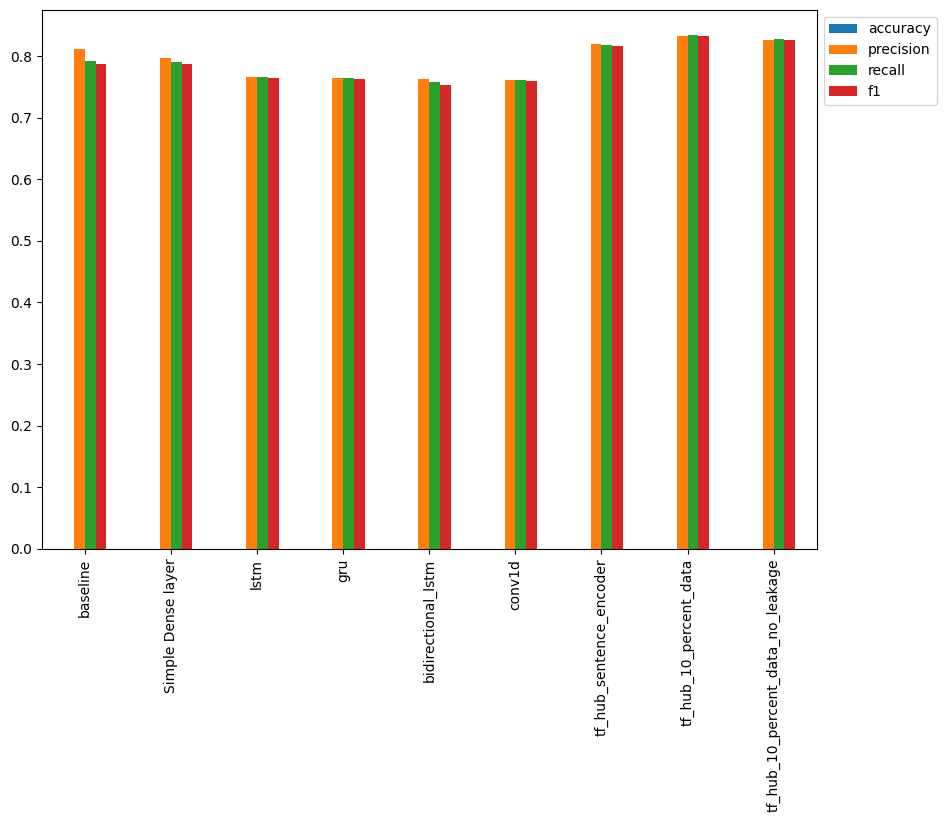

In [ ]:
all_model_results["accuracy"] = all_model_results["accuracy"]/100
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));